In [1]:
import os
from glob     import glob
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from CCdb   import _default_reference_file as references

from CCio   import load_hdf

from CCcore import in_range
from CCcore import rebin_df
from CCcore import filter_df
from CCcore import histogram
from CCcore import integrate_peak
from CCcore import power_to_quanta_rate
from CCcore import fix_hot_pixel
from CCcore import remove_duplicate_grating

from CCfit  import fit
from CCfit  import gauss

from CCplot import change_jupyter_width
from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import labels
from CCplot import normhist
from CCplot import plot1d
from CCplot import plot2d

In [2]:
exec(change_jupyter_width(90))

In [3]:
%matplotlib inline

auto_plot_style()

In [4]:
_default_column = "rate"

In [5]:
def plot_2d_array(dfs, exposure, column=_default_column):
    figure(len(dfs))
    for n, df in enumerate(dfs):
        subplot(len(dfs), n+1)
        df = filter_df(df, exposure=exposure)
        df = remove_duplicate_grating(df)
        spectrum = getattr(df, column)
        s, c = plot2d(df.ex_wl, df.em_wl, spectrum, title=str(n)
                     , log=True, zlabel=column
                     , cmin=np.percentile(spectrum, 5), cmax=spectrum.max())

    plt.tight_layout()

def plot_comparison_1d_array(dfs, exposure, column=_default_column):
    plt.figure(figsize=(6*4, 3*3))
    for n, df in enumerate(dfs):
        df = filter_df(df, exposure=exposure)
        df = remove_duplicate_grating(df)
        for ex_wl, data in df.groupby("ex_wl"):
            plt.subplot(3, 4, (ex_wl - 390) // 10)
            spectrum = getattr(data, column)
            plot1d(data.em_wl, spectrum, title=str(ex_wl), ylabel=column, label=str(n))

            if n == len(dfs) - 1:
                plt.fill_betweenx(plt.ylim(), ex_wl - 10, ex_wl + 10, color="y", alpha=0.5)
                if ex_wl == 400:
                    plt.legend(fontsize=10, ncol=1)

            wlmin = np.round(data.em_wl.min(), -2)
            wlmax = np.round(data.em_wl.max(), -2) + 1
            ticks = np.concatenate([ np.arange(wlmin, 1000, 200)
                                   , np.arange(1000, wlmax, 200)])

            plt.xticks(ticks)
    plt.tight_layout()
    
def integrate(wls, spectrum, wl_min, wl_max):
    sel = in_range(wls, wl_min, wl_max)
    return spectrum[sel].sum()

def plot_integrate(datas, crystal, ex_wl, exposure, ilimits, ylimits, rebin=4, loc=1):
    ints = []
    for k, data in enumerate(datas):
        data     = filter_df(data, exposure=exposure, ex_wl=ex_wl, grating_mono = 1 + int(ex_wl >= 400))
        integral = integrate(data.em_wl, data.rate / normalization(data.timestamp), *ilimits)

        data = rebin_df(data, rebin)
        plot1d(data.em_wl, data.rate / normalization(data.timestamp), ylabel="Rate (a.u.)", label=str(k))
        ints.append(integral)

    plt.title(f"{crystal} @ {ex_wl} nm, {exposure:.1f} s")
    plt.ylim(ylimits)
    plt.vlines(ilimits, *plt.ylim(), colors="g", ls="--")
    plt.legend(loc=loc)

    return ints

def plot_integrals(ints, crystal, ex_wl, exposure, log=False):
    ints = np.asarray(ints) / max(ints)
    plt.plot(np.arange(len(ints)), ints, "k.")
    plt.title(f"{crystal} @ {ex_wl} nm, {exposure:.1f} s")
    plt.xlabel("Irrad #")
    plt.ylabel("Integral (a.u)")
    if log:
        plt.yscale("log")

    xlim  = plt.xlim()
    ticks = np.arange(1, len(ints), 2)
    
    plt.xticks(ticks - 0.5, map(str, ticks//2))
    plt.grid(True, axis="x")

    ax = plt.gca().twiny()
    ax.set_xlabel("Anneal #")
    ax.set_xlim(xlim)
    ticks  = np.arange(0, len(ints), 2)
    ax.set_xticks(ticks - 0.5)
    ax.set_xticklabels(map(str, (ticks) // 2))
    ax.set_ylim(0, 1.1 * max(ints))
    ax.grid(True, axis="x")

In [7]:
folder = "/home/gonzalo/data/CC/LiFdrop/"

lifs_1 = []
lifs_2 = []
lifs_3 = []

for i in range(5):
    whats = "anneal irrad".split() if i!=3 else "anneal".split()
    for what in whats:
        lif_filename = glob(os.path.join(folder, f"scan_lifdrop{what}{i}_LiF_B1*.h5"))[0]
        lifs_1.append(fix_hot_pixel(load_hdf(lif_filename, "LiF")))
        lif_filename = glob(os.path.join(folder, f"scan_lifdrop{what}{i}_LiF_B2*.h5"))[0]
        lifs_2.append(fix_hot_pixel(load_hdf(lif_filename, "LiF")))
        lif_filename = glob(os.path.join(folder, f"scan_lifdrop{what}{i}_LiF_B3*.h5"))[0]
        lifs_3.append(fix_hot_pixel(load_hdf(lif_filename, "LiF")))


In [8]:
from scipy.interpolate import interp1d

df = pd.read_hdf("/home/gonzalo/data/CC/pre-annealing-experiment/power_normalization.h5", "/integrals")
df = df.assign(norm = df.integral / df.integral.max() )

normalization = interp1d(df.timestamp, df.norm, )
#normalization = lambda x: np.ones_like(x)

# LiF B1

/home/gonzalo/sw/git/CC/CCcore.py:32: RuntimeWarning: invalid value encountered in greater_equal
  if low  is not None: sel &= x >= low
/home/gonzalo/sw/git/CC/CCcore.py:33: RuntimeWarning: invalid value encountered in less
  if high is not None: sel &= x <  high
/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


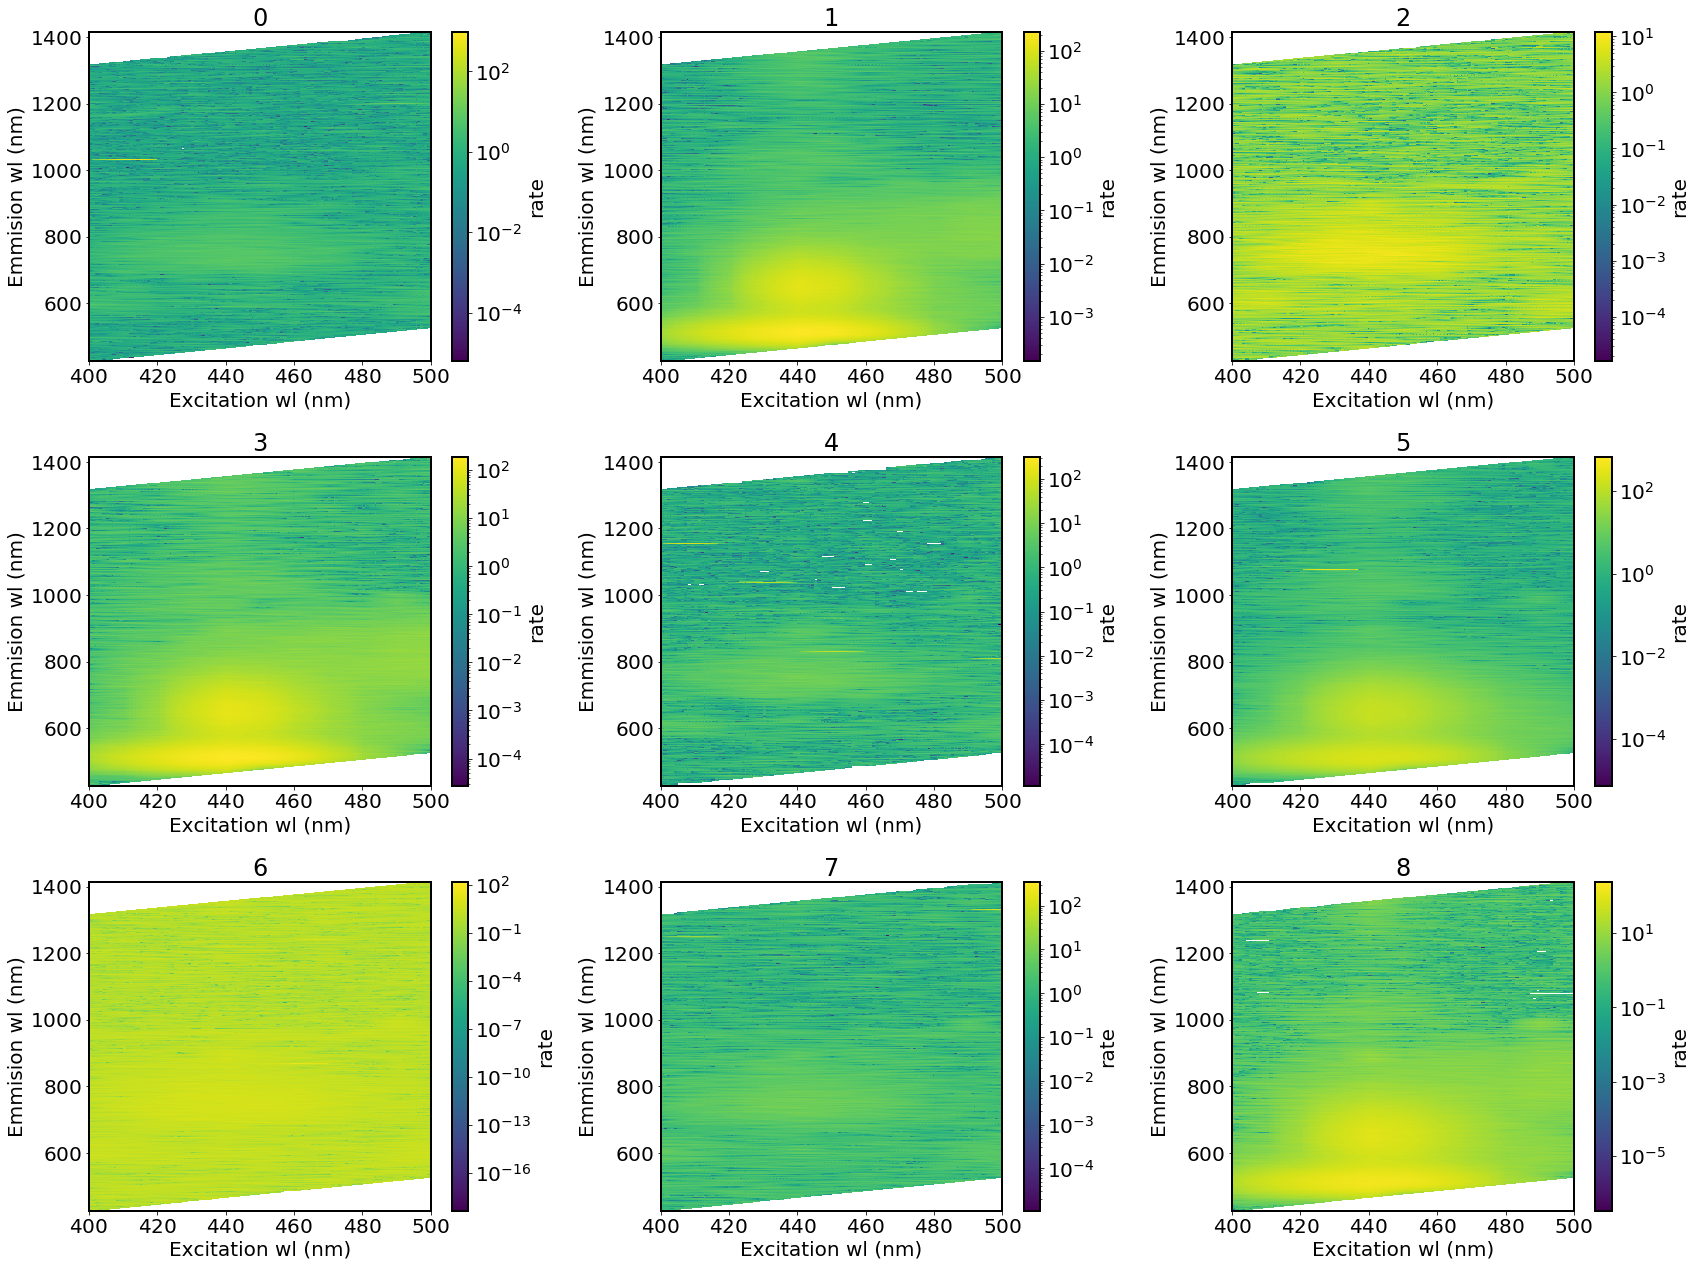

In [9]:
plot_2d_array(lifs_1, 10)

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


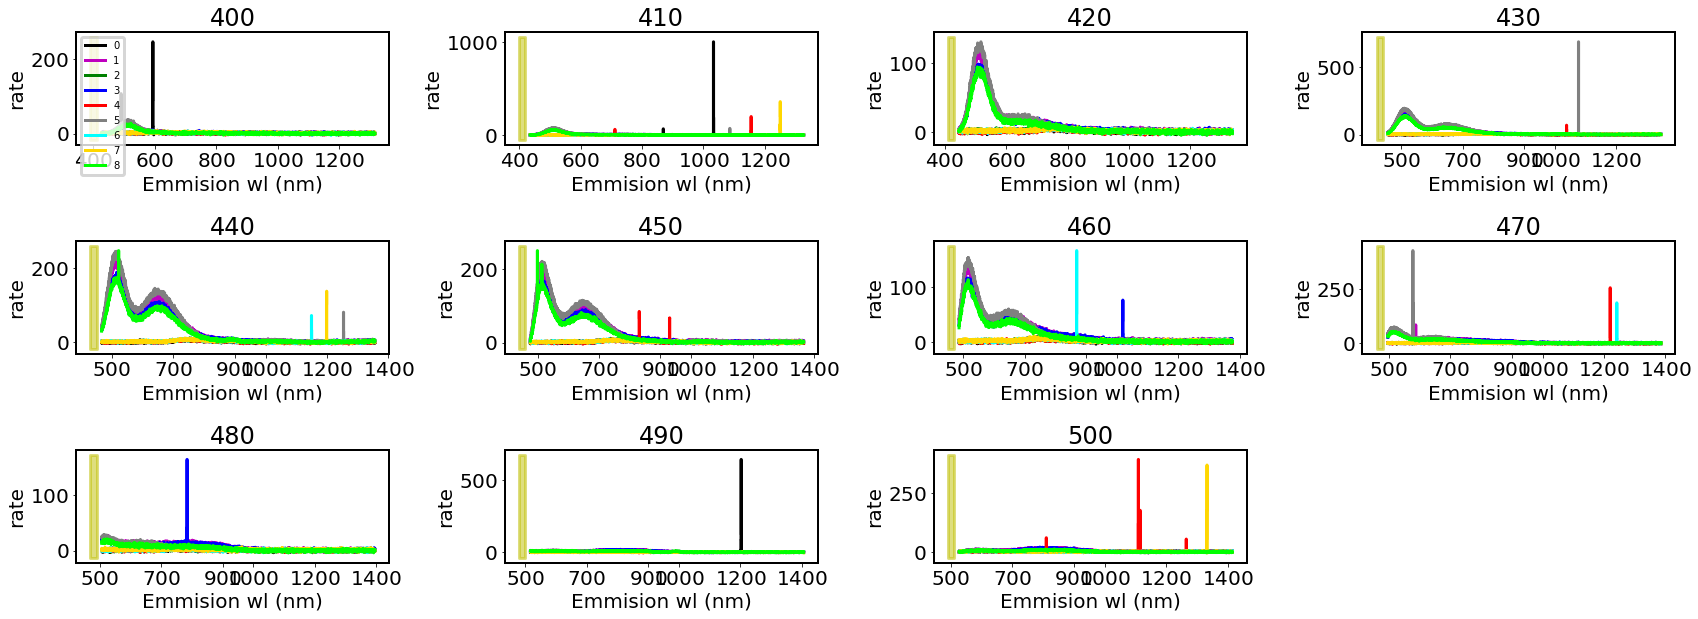

In [10]:
plot_comparison_1d_array(lifs_1, 10)

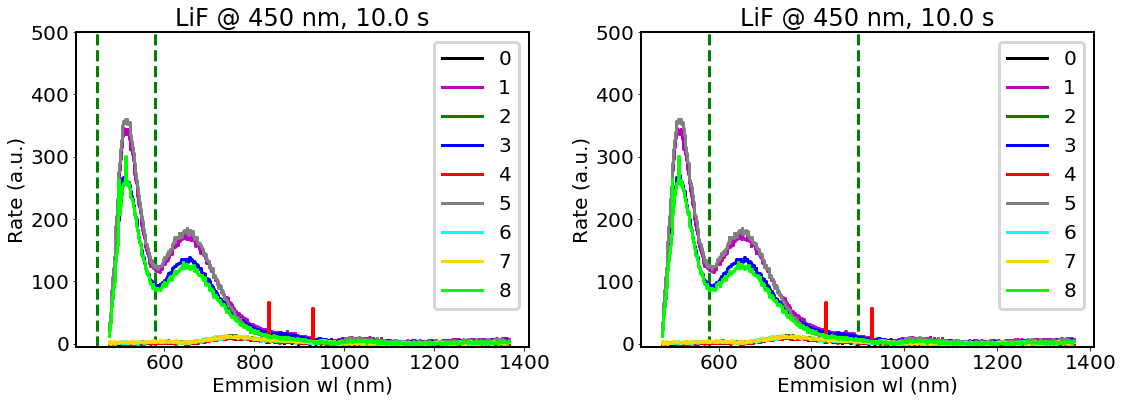

In [11]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
lif1_450_530 = plot_integrate(lifs_1, "LiF", 450, 10, (450, 580), (-5, 500))
plt.subplot(1, 2, 2)
lif1_450_680 = plot_integrate(lifs_1, "LiF", 450, 10, (580, 900), (-5, 500))

plt.tight_layout()

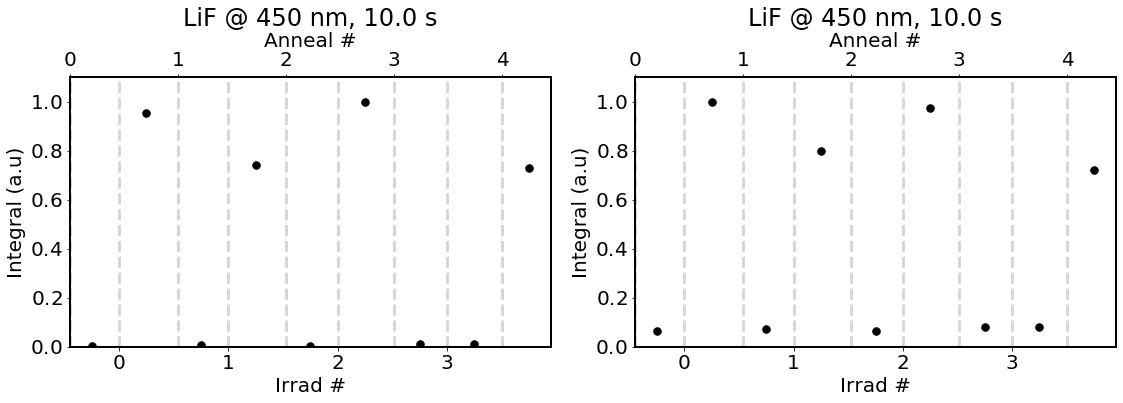

In [12]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
plot_integrals(lif1_450_530, "LiF", 450, 10)
plt.subplot(1, 2, 2)
plot_integrals(lif1_450_680, "LiF", 450, 10)
plt.tight_layout()

# LiF B2

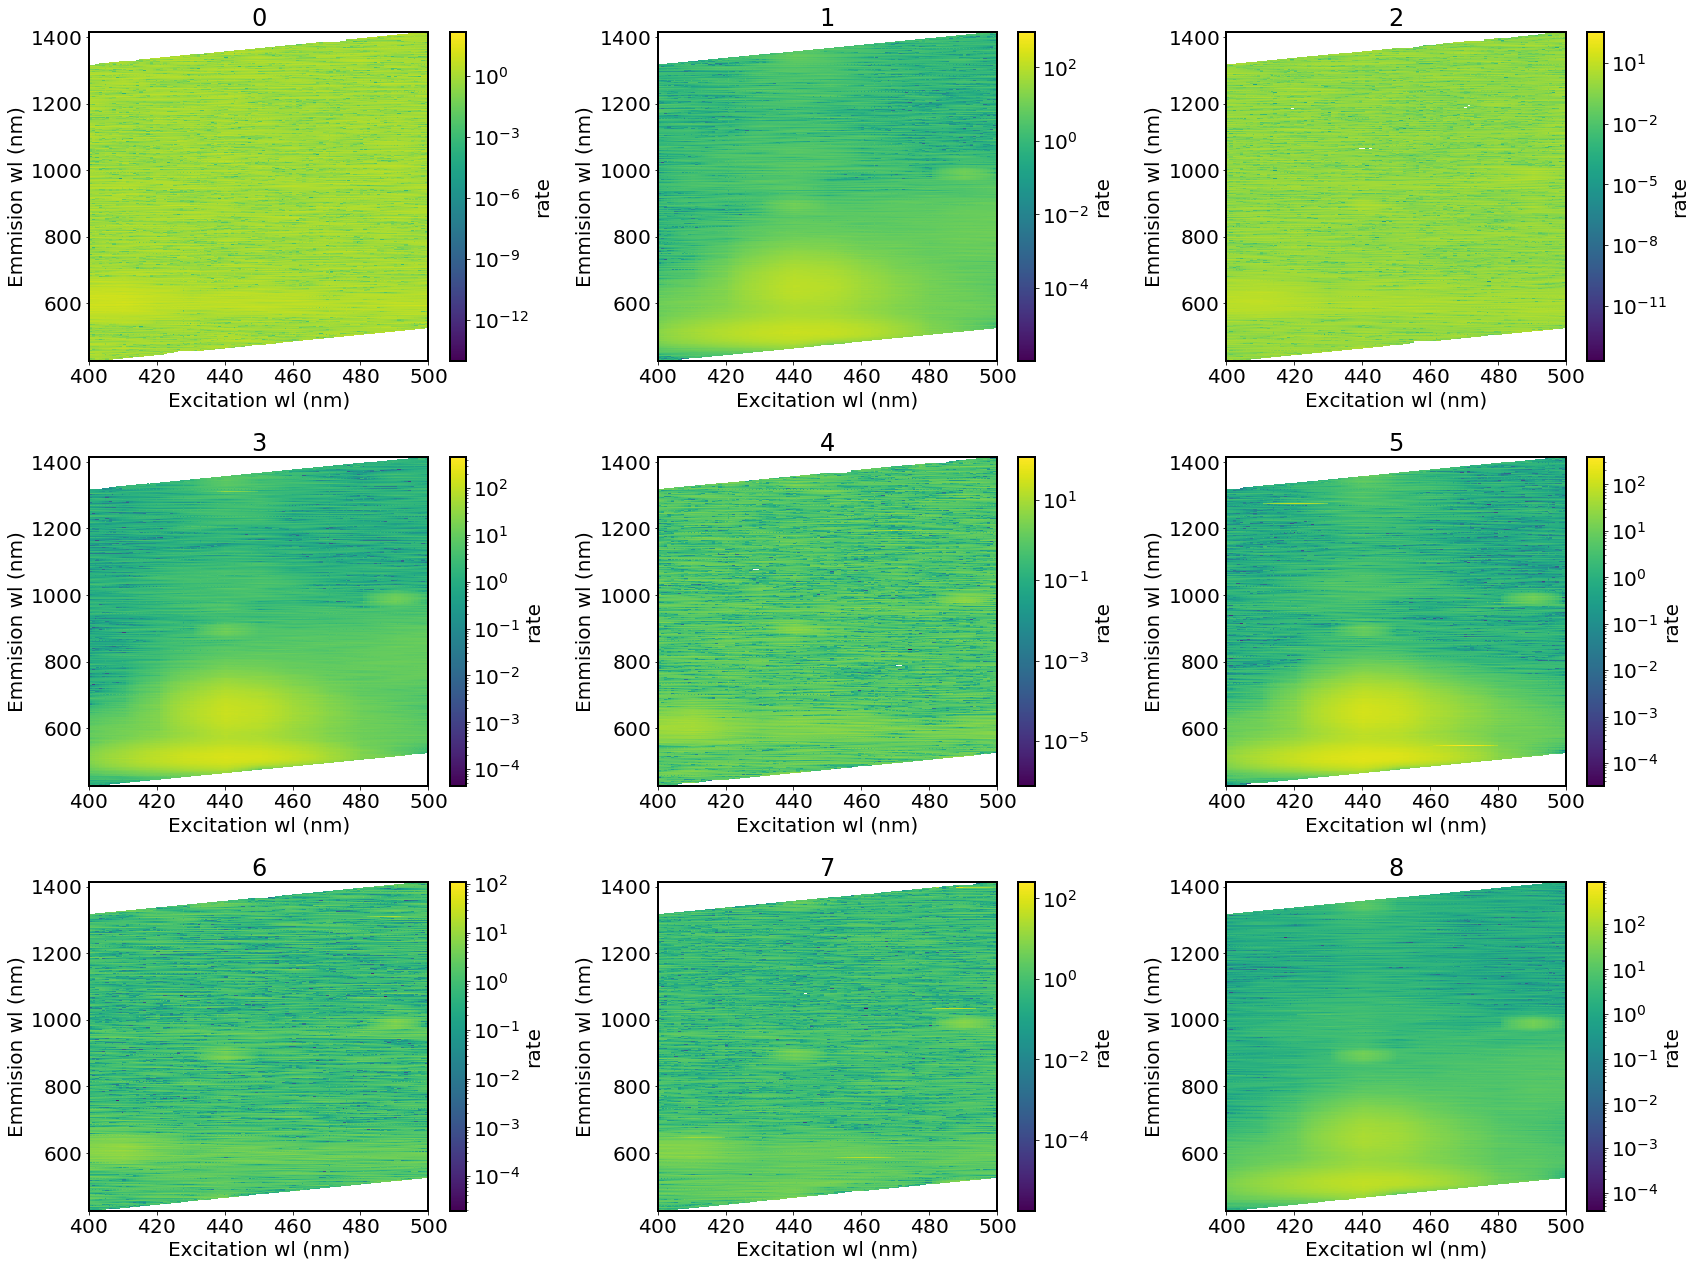

In [13]:
plot_2d_array(lifs_2, 10)

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


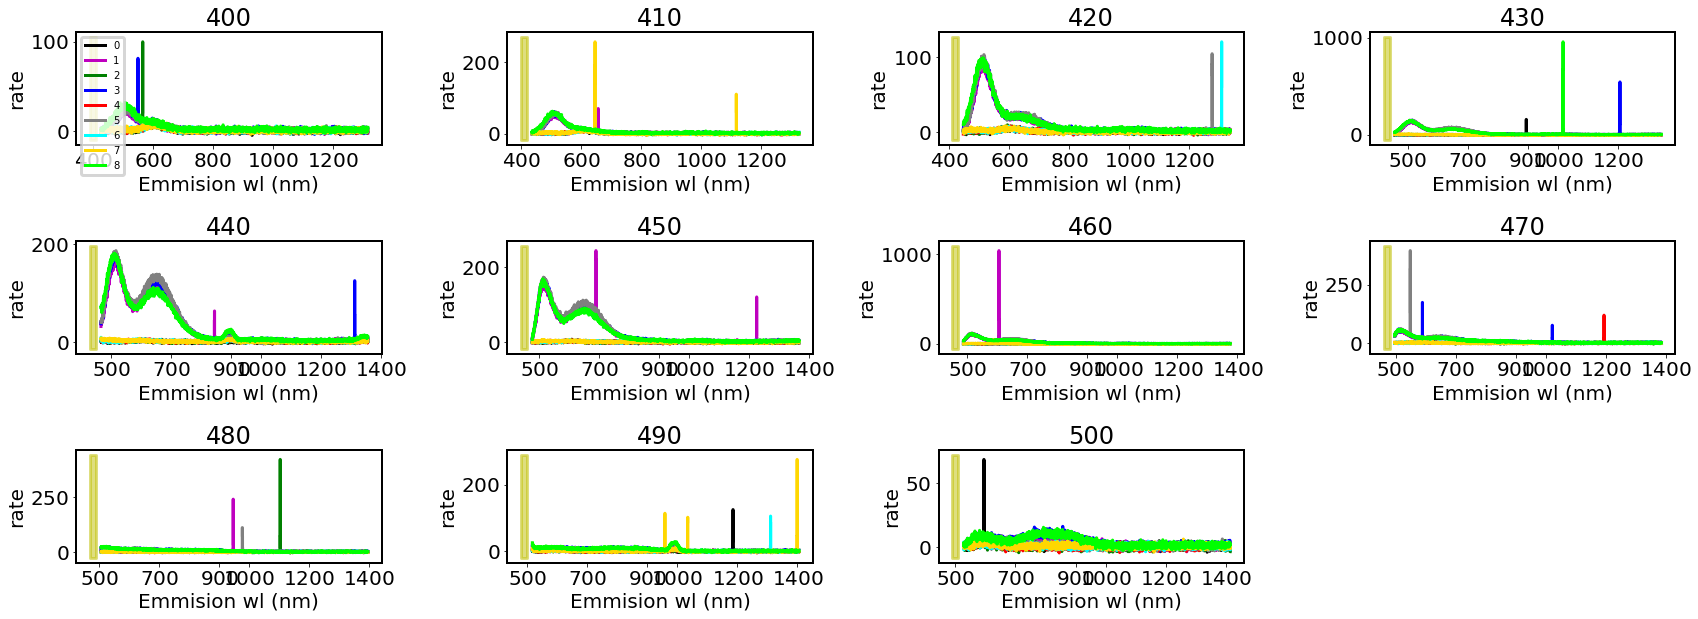

In [14]:
plot_comparison_1d_array(lifs_2, 10)

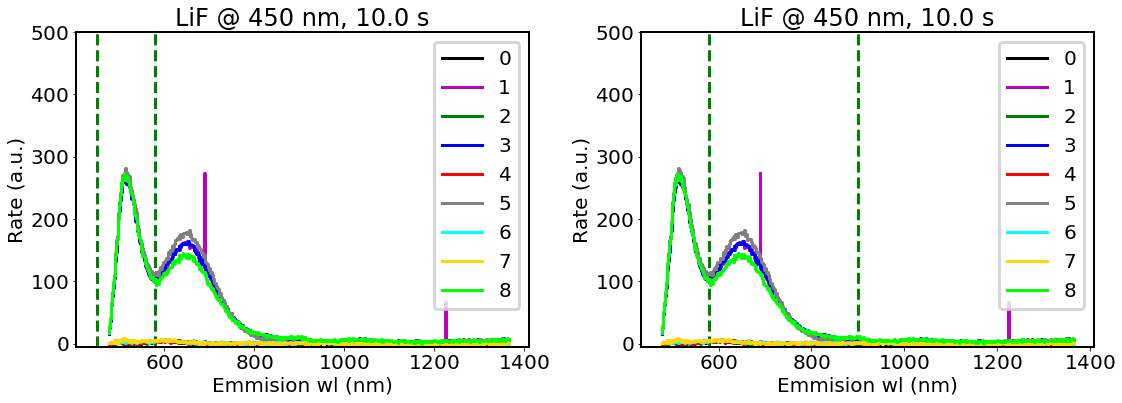

In [15]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
lif2_450_530 = plot_integrate(lifs_2, "LiF", 450, 10, (450, 580), (-5, 500))
plt.subplot(1, 2, 2)
lif2_450_680 = plot_integrate(lifs_2, "LiF", 450, 10, (580, 900), (-5, 500))

plt.tight_layout()

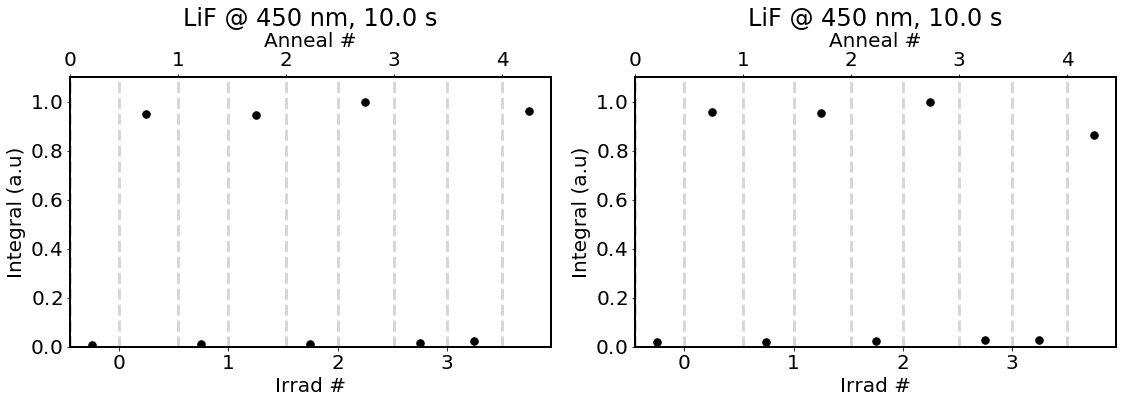

In [16]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
plot_integrals(lif2_450_530, "LiF", 450, 10)
plt.subplot(1, 2, 2)
plot_integrals(lif2_450_680, "LiF", 450, 10)
plt.tight_layout()

# LiF B3

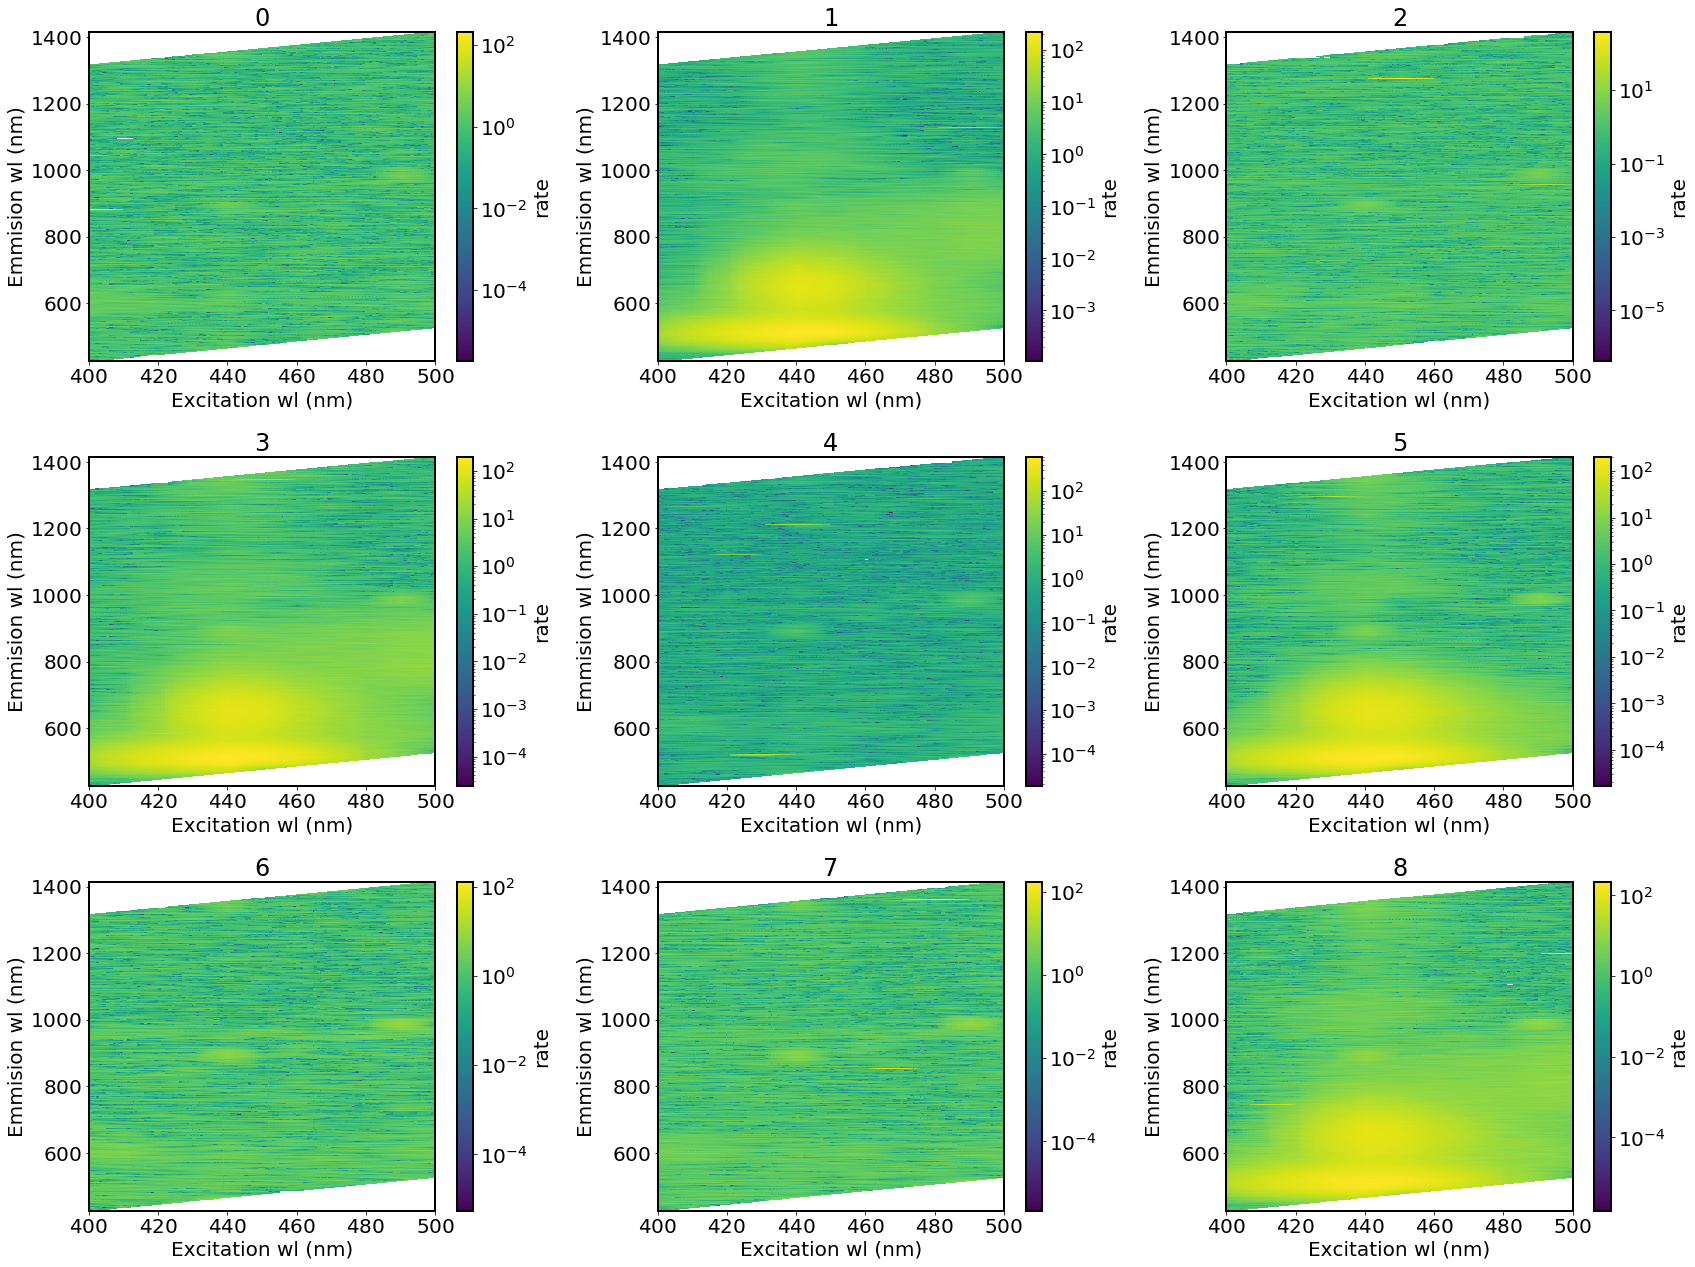

In [17]:
plot_2d_array(lifs_3, 10)

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


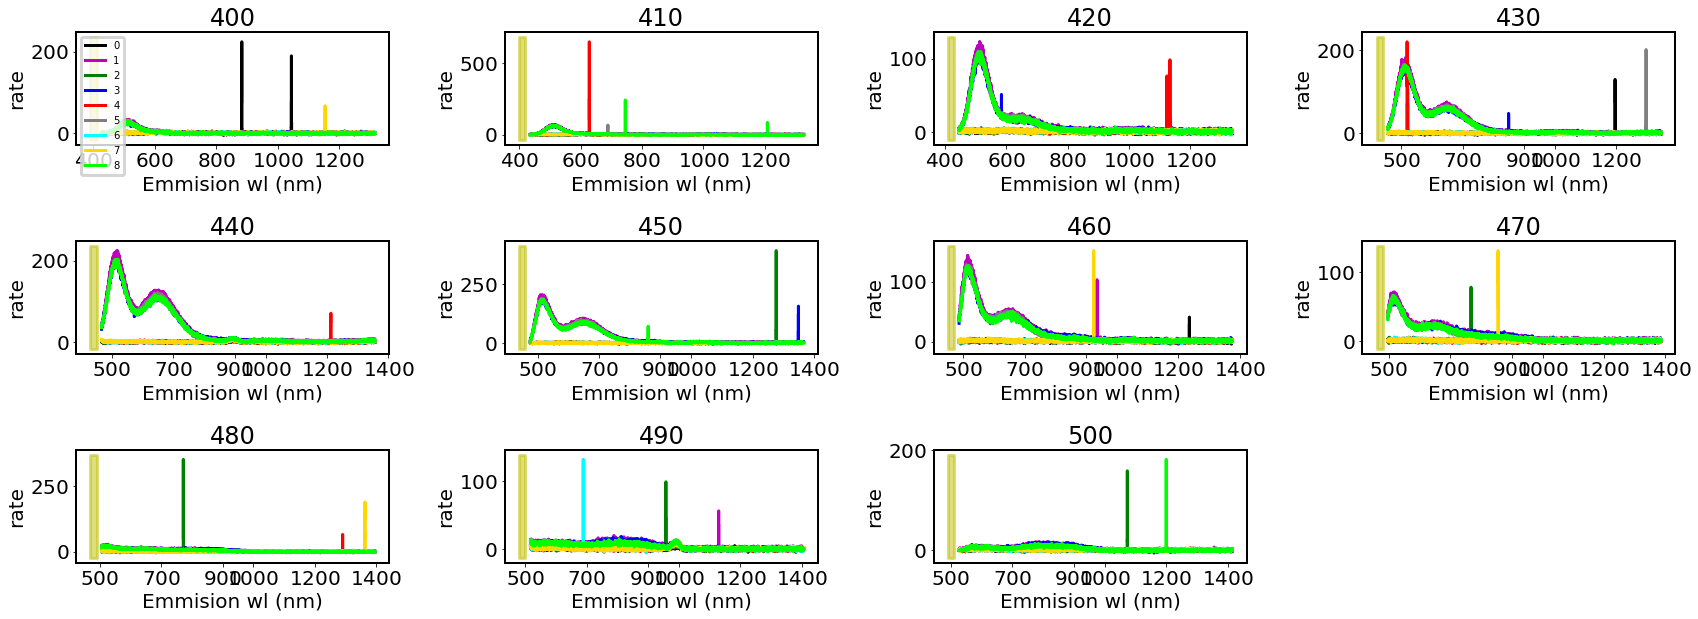

In [18]:
plot_comparison_1d_array(lifs_3, 10)

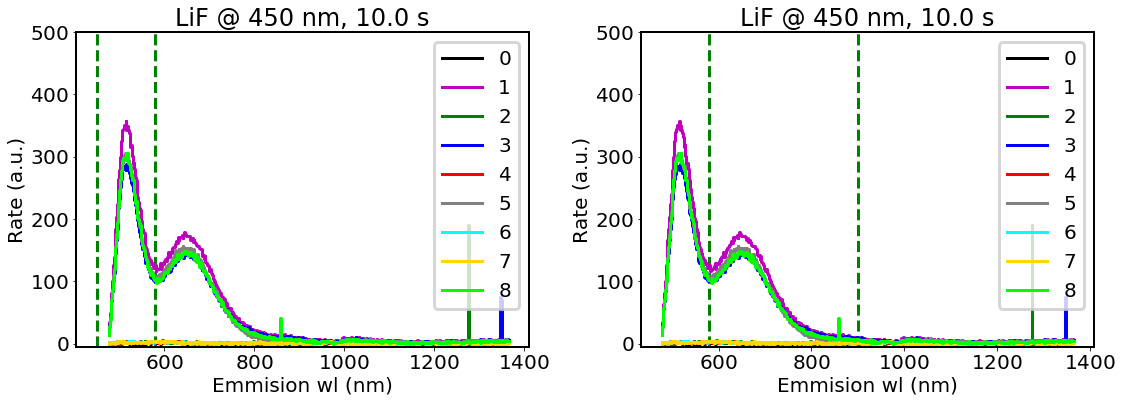

In [19]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
lif3_450_530 = plot_integrate(lifs_3, "LiF", 450, 10, (450, 580), (-5, 500))
plt.subplot(1, 2, 2)
lif3_450_680 = plot_integrate(lifs_3, "LiF", 450, 10, (580, 900), (-5, 500))

plt.tight_layout()

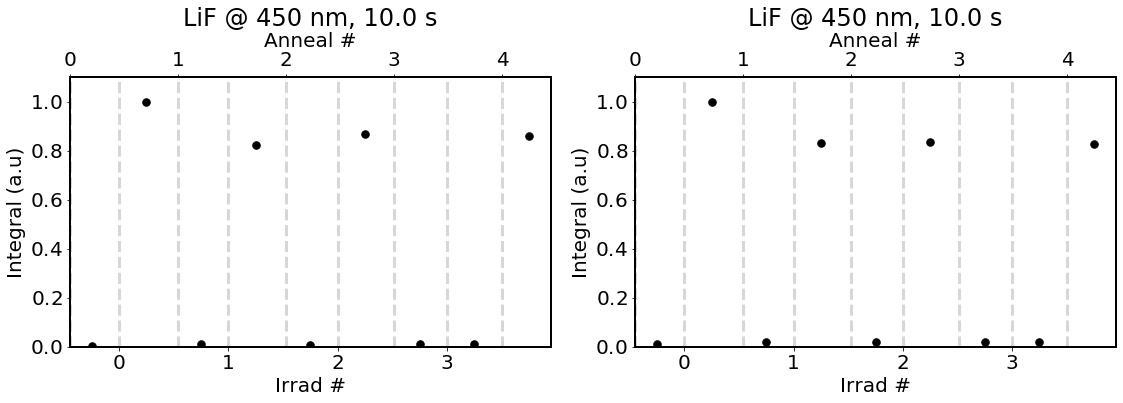

In [20]:
plt.figure(figsize=(8*2, 6*1))
plt.subplot(1, 2, 1)
plot_integrals(lif3_450_530, "LiF", 450, 10)
plt.subplot(1, 2, 2)
plot_integrals(lif3_450_680, "LiF", 450, 10)
plt.tight_layout()